In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scanpy as sc
import scvi
import pathlib
import warnings
import gc
import os
import random
warnings.filterwarnings('ignore')

sc.set_figure_params(figsize=(4, 4))

import torch
#import gdown
import copy as cp
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

[rank: 0] Global seed set to 0


In [2]:
print(torch.cuda.is_available)

<function is_available at 0x15268fd84b80>


## Data loading

In [3]:
Atlas = sc.read_h5ad('/rwthfs/rz/cluster/home/noco0013/projects/novo_postdoc/data/news_scVI_Atherosclerosis_atlas.h5ad')

In [4]:
scvi.model.SCVI.setup_anndata(Atlas, layer="counts", batch_key="Donor")
vaes = scvi.model.SCVI(Atlas)
vaes = vaes.load("/rwthfs/rz/cluster/home/noco0013/projects/novo_postdoc/data/new_scVI_vaes", Atlas)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     File /rwthfs/rz/cluster/home/noco0013/projects/novo_postdoc/data/new_scVI_vaes/model.pt already downloaded


In [5]:
Atlas

AnnData object with n_obs × n_vars = 135032 × 8000
    obs: 'nCount_RNA', 'nFeature_RNA', 'Tissue', 'Disease', 'Donor', 'Study', 'State', 'Artery', 'Assay', 'percent.mt', 'Doublets', 'Sex', '_scvi_batch', '_scvi_labels', 'leiden01', 'leiden02'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'Study_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden01_colors', 'leiden02_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
#Add Annotation
cell_dict = {'VSMC': ['0'], 'T cells': ['1'], 'Macrophage': ['2'], 'Fibroblast': ['3'],
    'Endothelial_1': ['4'], 'Pericytes': ['5'], 'Endothelial_2': ['6'],
             'B cells':['7'], 'Mast cells': ['8'],  'Osteoblastic cells': ['9'], "Plasma cells":["10"],
             "Neuronal cells":["11"], "Lymphatic Endothelial":["12"], "cDC1":["13"], "pDC":["14"], "Neutrophils":["15"]}
Atlas.obs['Main_Cell_Types'] = np.nan
for i in cell_dict.keys():
    ind = pd.Series(Atlas.obs.leiden02).isin(cell_dict[i])
    Atlas.obs.loc[ind,'Main_Cell_Types'] = i

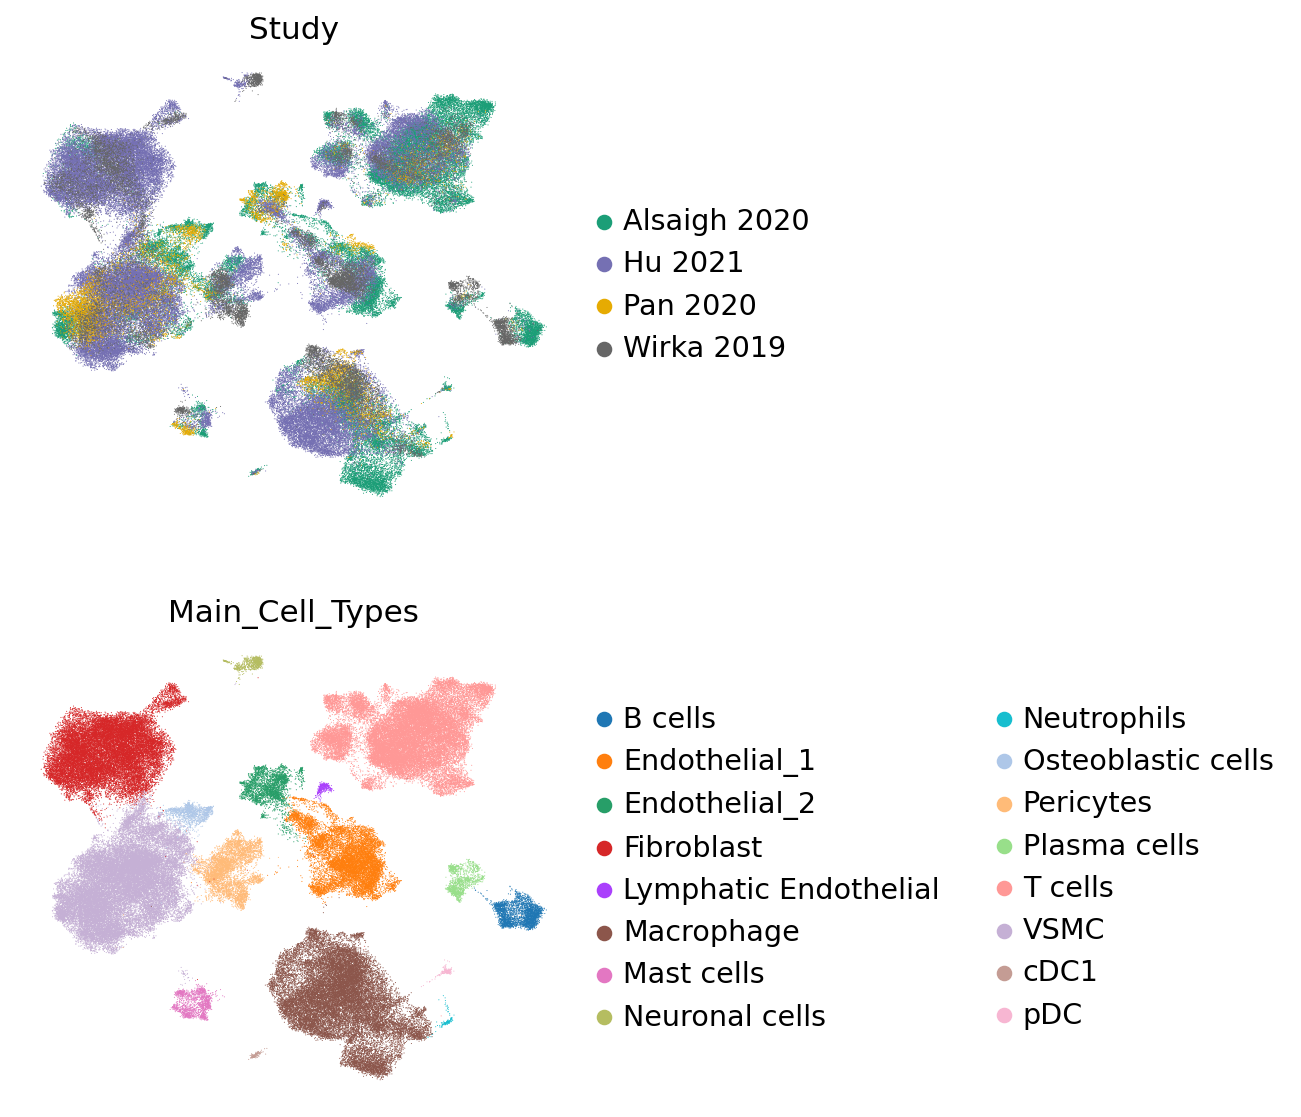

In [7]:
sc.pl.umap(
    Atlas,
    color=["Study", "Main_Cell_Types"],
    frameon=False,
    ncols=1,
)

## Subclustering with different resolutions

In [10]:
random.seed(89)

for cluster in np.unique(Atlas.obs.Main_Cell_Types):
    print(cluster)
    subset = Atlas[Atlas.obs["Main_Cell_Types"] == cluster]
    subset = subset.copy()
    scvi.model.SCVI.setup_anndata(subset, layer="counts", batch_key="Donor")
    vae_subset = scvi.model.SCVI(subset, n_layers=2, n_latent=30, gene_likelihood="nb")
    vae_subset.train()
    subset.obsm["X_scVI"] = vae_subset.get_latent_representation()
    sc.pp.neighbors(subset, use_rep="X_scVI")
    sc.tl.leiden(subset, resolution=0.1, key_added="leiden01")
    sc.tl.leiden(subset, resolution=0.2, key_added="leiden02")
    sc.tl.leiden(subset, resolution=0.3, key_added="leiden03")
    sc.tl.leiden(subset, resolution=0.4, key_added="leiden04")
    sc.tl.leiden(subset, resolution=0.5, key_added="leiden05")
    sc.tl.leiden(subset, resolution=0.6, key_added="leiden06")
    sc.tl.umap(subset)
    file_name = cluster + '_subclustering.h5ad'
    model_name = 'vaes_' + cluster
    path = '/rwthfs/rz/cluster/home/noco0013/projects/novo_postdoc/data/Atherosclerosis/Subclustering'
    file_path = os.path.join(path, file_name)
    model_path = os.path.join(path, model_name)
    subset.write(file_path)
    vae_subset.save(model_path)

B cells


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [01:19<00:00,  5.11it/s, loss=829, v_num=1] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:19<00:00,  5.00it/s, loss=829, v_num=1]
Endothelial


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [05:01<00:00,  1.15it/s, loss=1.58e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:01<00:00,  1.33it/s, loss=1.58e+03, v_num=1]
Endothelial (DKK2+)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [01:26<00:00,  4.40it/s, loss=1.84e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:27<00:00,  4.60it/s, loss=1.84e+03, v_num=1]
Fibroblast


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 347/347: 100%|██████████| 347/347 [09:09<00:00,  1.57s/it, loss=1.79e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=347` reached.


Epoch 347/347: 100%|██████████| 347/347 [09:09<00:00,  1.58s/it, loss=1.79e+03, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Lymphatic Endothelial
Epoch 400/400: 100%|██████████| 400/400 [00:13<00:00, 29.90it/s, loss=1.21e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:13<00:00, 29.94it/s, loss=1.21e+03, v_num=1]
Macrophage


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 323/323: 100%|██████████| 323/323 [09:21<00:00,  1.76s/it, loss=1.91e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=323` reached.


Epoch 323/323: 100%|██████████| 323/323 [09:21<00:00,  1.74s/it, loss=1.91e+03, v_num=1]
Mast cells


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [00:45<00:00,  8.89it/s, loss=947, v_num=1]     

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:45<00:00,  8.71it/s, loss=947, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Neuronal cells
Epoch 400/400: 100%|██████████| 400/400 [00:26<00:00, 15.89it/s, loss=858, v_num=1]   

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:26<00:00, 15.22it/s, loss=858, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Neutrophils
Epoch 400/400: 100%|██████████| 400/400 [00:05<00:00, 66.80it/s, loss=382, v_num=1]   

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:05<00:00, 67.29it/s, loss=382, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Osteoblastic cells
Epoch 400/400: 100%|██████████| 400/400 [00:42<00:00,  9.20it/s, loss=1.7e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:42<00:00,  9.45it/s, loss=1.7e+03, v_num=1]
Pericytes


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [02:19<00:00,  2.92it/s, loss=1.39e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:19<00:00,  2.86it/s, loss=1.39e+03, v_num=1]


GPU available: True (cuda), used: True


Plasma cells


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [00:41<00:00,  9.78it/s, loss=1.67e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:41<00:00,  9.53it/s, loss=1.67e+03, v_num=1]
T cells


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 276/276: 100%|██████████| 276/276 [09:11<00:00,  1.95s/it, loss=1e+03, v_num=1]   

`Trainer.fit` stopped: `max_epochs=276` reached.


Epoch 276/276: 100%|██████████| 276/276 [09:11<00:00,  2.00s/it, loss=1e+03, v_num=1]
VSMC


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 255/255: 100%|██████████| 255/255 [09:05<00:00,  2.10s/it, loss=1.75e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=255` reached.


Epoch 255/255: 100%|██████████| 255/255 [09:05<00:00,  2.14s/it, loss=1.75e+03, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


cDC1
Epoch 400/400: 100%|██████████| 400/400 [00:09<00:00, 39.19it/s, loss=1.93e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:09<00:00, 41.79it/s, loss=1.93e+03, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


pDC
Epoch 400/400: 100%|██████████| 400/400 [00:10<00:00, 42.88it/s, loss=1.65e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:10<00:00, 39.10it/s, loss=1.65e+03, v_num=1]
